In [59]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import shap

In [60]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Provide the path to the file in your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/DBA5102/Advertising_Kaggle/data/Advertising Budget and Sales.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0  TV Ad Budget ($)  Radio Ad Budget ($)  Newspaper Ad Budget ($)  \
0           1             230.1                 37.8                     69.2   
1           2              44.5                 39.3                     45.1   
2           3              17.2                 45.9                     69.3   
3           4             151.5                 41.3                     58.5   
4           5             180.8                 10.8                     58.4   

   Sales ($)  
0       22.1  
1       10.4  
2        9.3  
3       18.5  
4       12.9  


<h1>EDA & Feature Engineering</h1>

In [62]:
# Rename columns for easier access
df.rename(columns={
    'TV Ad Budget ($)': 'TV_Budget',
    'Radio Ad Budget ($)': 'Radio_Budget',
    'Newspaper Ad Budget ($)': 'Newspaper_Budget',
    'Sales ($)': 'Sales'
}, inplace=True)

In [63]:
# Check data types
print(df.dtypes)

# Convert columns to numeric if necessary
df = df.astype({
    'TV_Budget': 'float',
    'Radio_Budget': 'float',
    'Newspaper_Budget': 'float',
    'Sales': 'float'
})

Unnamed: 0            int64
TV_Budget           float64
Radio_Budget        float64
Newspaper_Budget    float64
Sales               float64
dtype: object


In [64]:
df.describe()

,Unnamed: 0,TV_Budget,Radio_Budget,Newspaper_Budget,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [65]:
# Check for missing values
print(df.isnull().sum())

Unnamed: 0          0
TV_Budget           0
Radio_Budget        0
Newspaper_Budget    0
Sales               0
dtype: int64


In [66]:
# Check for duplicates
print(df.duplicated().sum())

# Remove duplicates if any
df.drop_duplicates(inplace=True)

0


In [67]:
# Create a new column for total advertising budget
df['Total_Budget'] = df['TV_Budget'] + df['Radio_Budget'] + df['Newspaper_Budget']

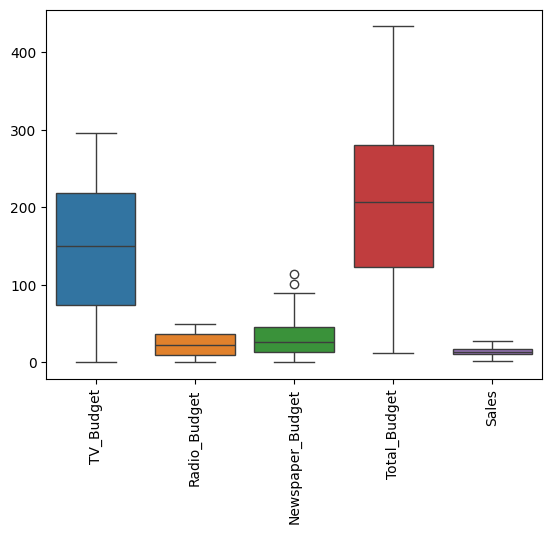

In [68]:
ax = sns.boxplot(data=df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget', 'Sales']])
ax.tick_params(axis='x', rotation=90)
plt.show()

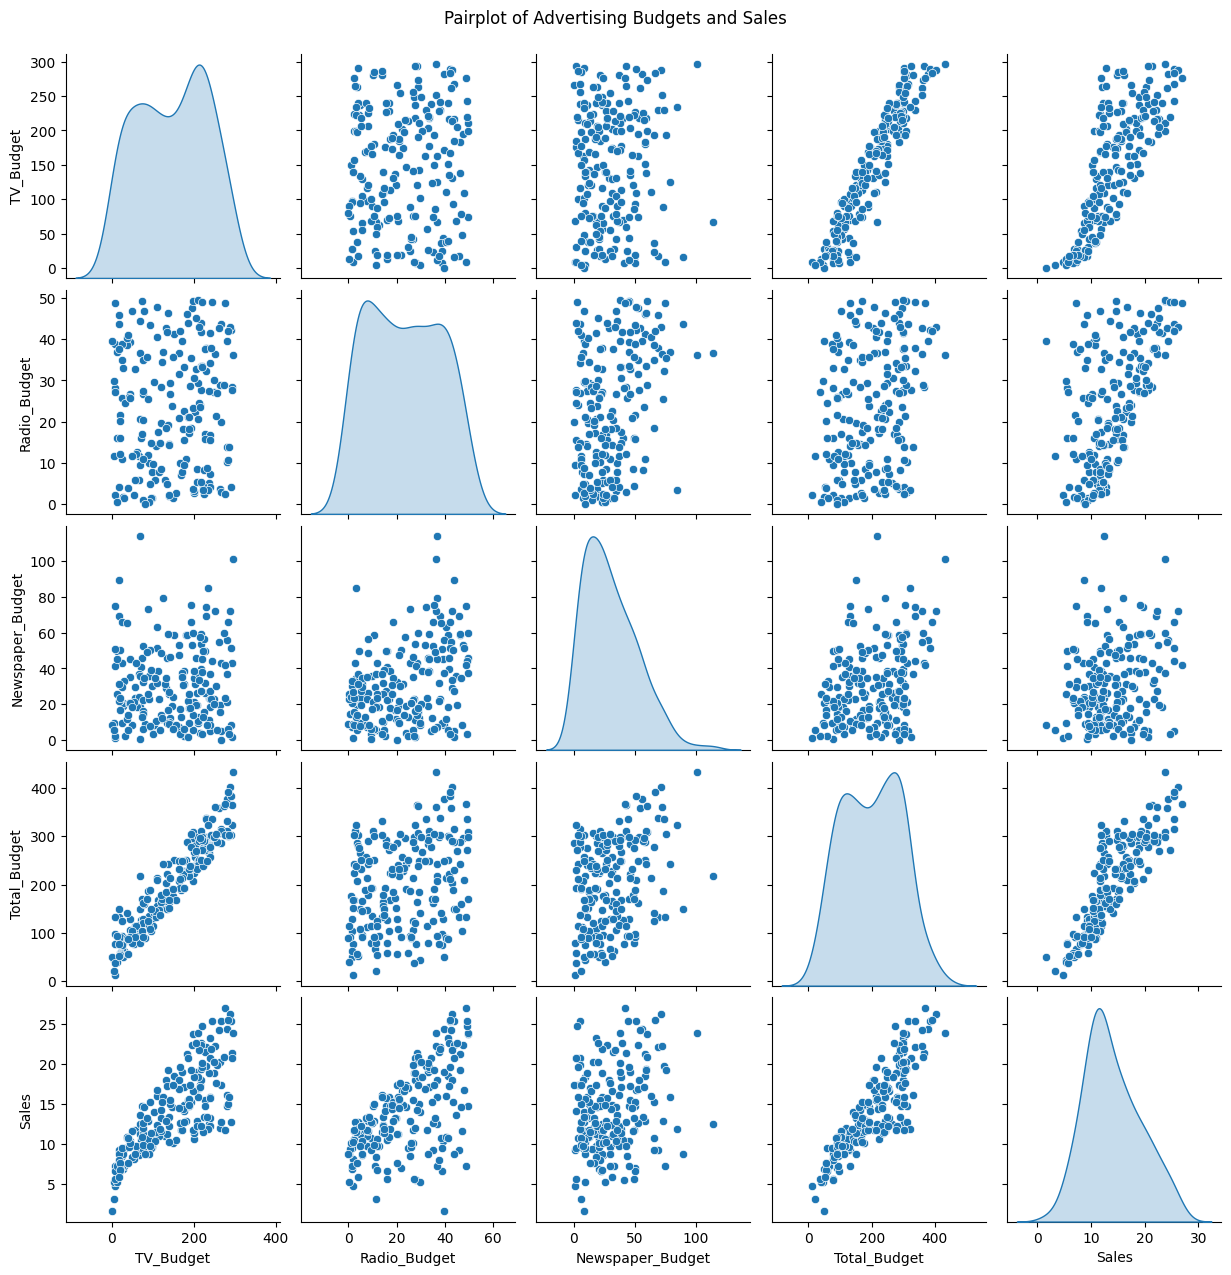

In [69]:
# Visualize distributions of advertising budgets and sales
sns.pairplot(df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget', 'Sales']], diag_kind='kde')
plt.suptitle("Pairplot of Advertising Budgets and Sales", y=1.02)
plt.show()

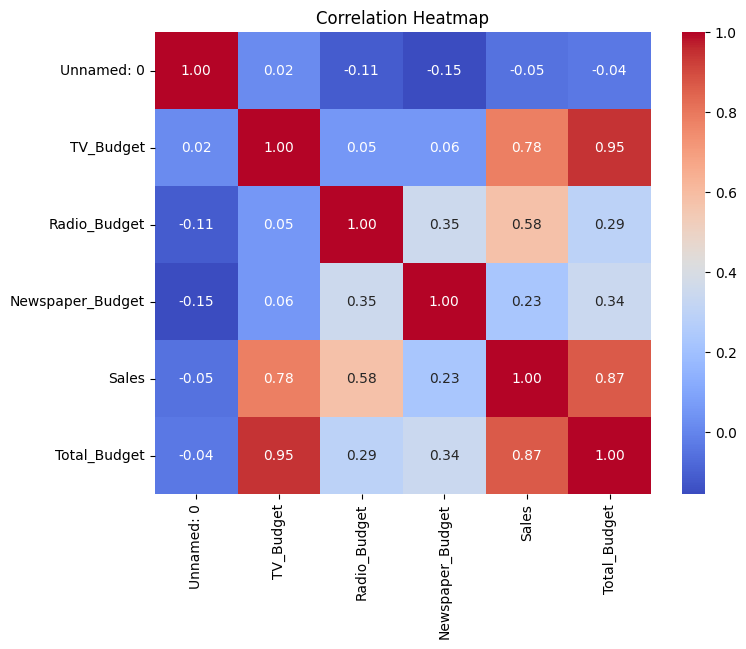

In [70]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

<h1>Modelling</h1>

In [71]:
# Features (X) and Target (y)
X = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget']]
y = df['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}\n\n")

# Identify the best-performing model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]
print(f"\nBest Performing Model: {best_model_name}")


Linear Regression Performance:
MAE: 1.46, RMSE: 1.78, R2: 0.90



Random Forest Performance:
MAE: 0.89, RMSE: 1.12, R2: 0.96



Gradient Boosting Performance:
MAE: 0.72, RMSE: 0.94, R2: 0.97



XGBoost Performance:
MAE: 0.74, RMSE: 0.96, R2: 0.97



Best Performing Model: Gradient Boosting


<h1>Explainability</h1>

In [74]:
# Permutation Feature Importance
perm_importance = permutation_importance(best_model, X_test, y_test, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)
print("\nPermutation Feature Importance:")
print(feature_importance)


Permutation Feature Importance:
            Feature  Importance
3      Total_Budget    0.965420
1      Radio_Budget    0.484014
0         TV_Budget    0.154746
2  Newspaper_Budget    0.019303


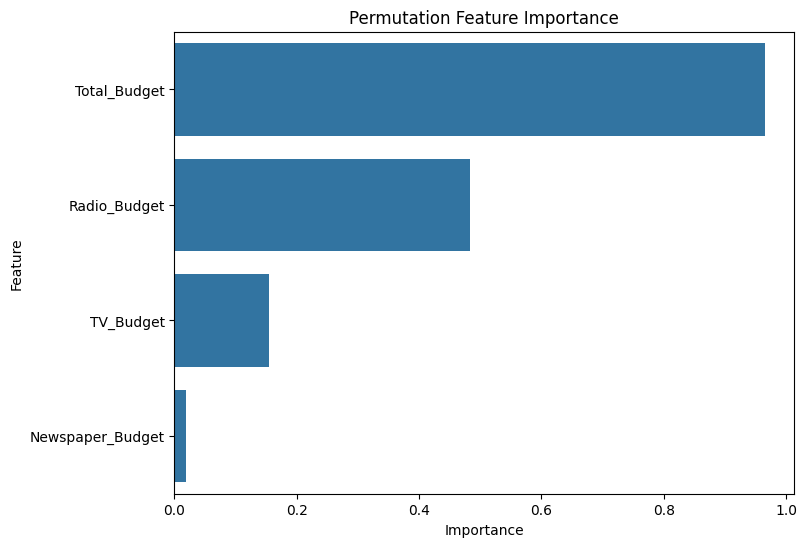

In [75]:
# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Permutation Feature Importance")
plt.show()

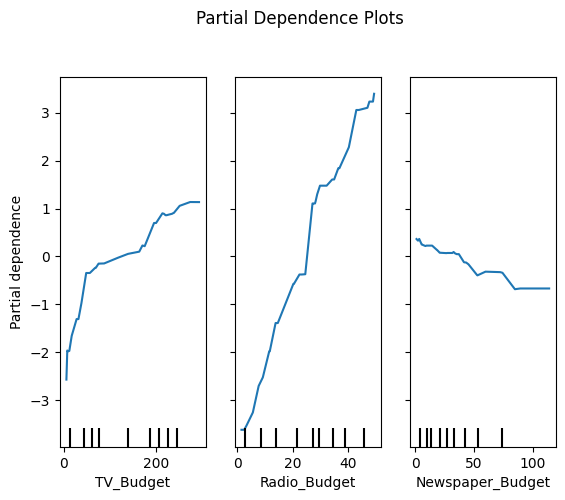

In [76]:
# Partial Dependence Plots (PDP)
PartialDependenceDisplay.from_estimator(best_model, X_test, features=[0, 1, 2], feature_names=X.columns)
plt.suptitle("Partial Dependence Plots", y=1.02)
plt.show()


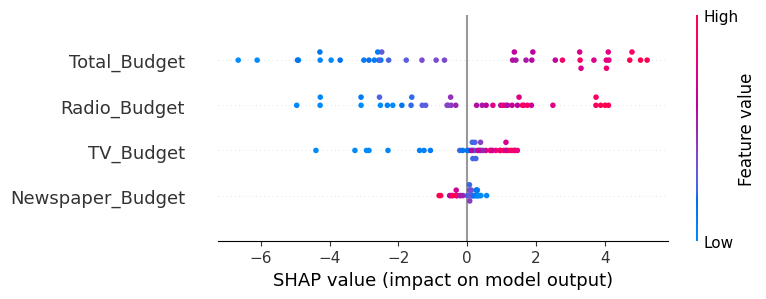

In [77]:
# Initialize SHAP JavaScript visualization
shap.initjs()

# Create SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Global SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

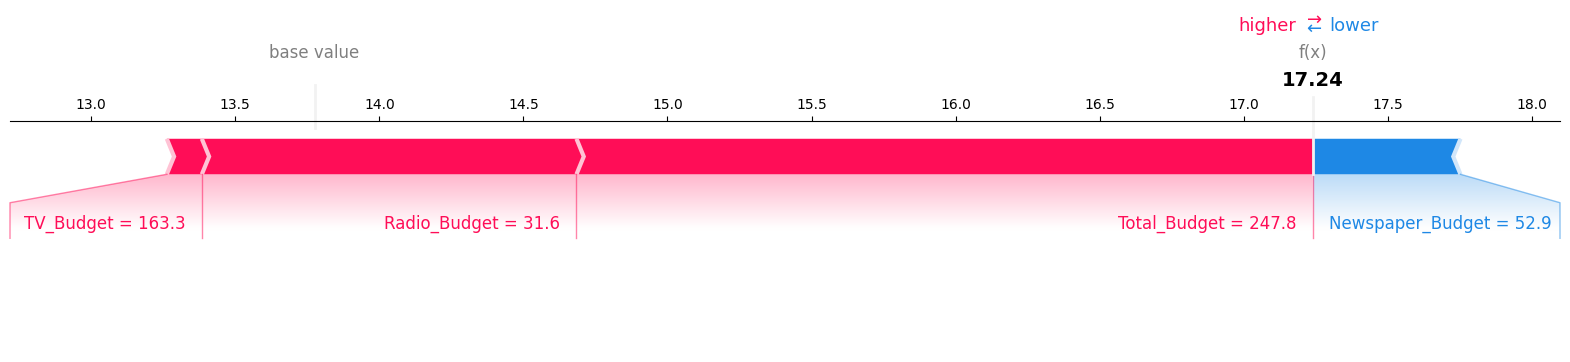

In [80]:
# Local SHAP Explanation for a single prediction
# Use matplotlib=True to render the force plot as a static image in Colab
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :], matplotlib=True)

# Marketing Channel Optimization

In [82]:
# Simulate budget adjustments
def simulate_budget_adjustment(tv, radio, newspaper):
    new_data = pd.DataFrame({'TV_Budget': [tv], 'Radio_Budget': [radio], 'Newspaper_Budget': [newspaper], 'Total_Budget': [tv+radio+newspaper]})
    predicted_sales = best_model.predict(new_data)
    return predicted_sales[0]

# Example: Simulate a new budget allocation
tv_budget = 200
radio_budget = 50
newspaper_budget = 30
predicted_sales = simulate_budget_adjustment(tv_budget, radio_budget, newspaper_budget)
print(f"\nPredicted Sales for TV: ${tv_budget}, Radio: ${radio_budget}, Newspaper: ${newspaper_budget} -> ${predicted_sales:.2f}")


Predicted Sales for TV: $200, Radio: $50, Newspaper: $30 -> $22.56
